In [19]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(   )


In [39]:
df= pd.read_parquet('data/yellow_tripdata_2023-01.parquet')
df_val= pd.read_parquet('data/yellow_tripdata_2023-02.parquet')
df.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [4]:
df.shape

(3066766, 19)

In [9]:
df.dtypes

VendorID                           int64
tpep_pickup_datetime      datetime64[us]
tpep_dropoff_datetime     datetime64[us]
passenger_count                  float64
trip_distance                    float64
RatecodeID                       float64
store_and_fwd_flag                object
PULocationID                       int64
DOLocationID                       int64
payment_type                       int64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
congestion_surcharge             float64
airport_fee                      float64
duration                 timedelta64[us]
dtype: object

## Computing new Variable Duration

In [16]:
df['duration']=df['tpep_dropoff_datetime']-df['tpep_pickup_datetime']
df['duration_minutes']= df['duration'].dt.total_seconds()/60

df['duration_minutes'].head


<bound method NDFrame.head of 0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration_minutes, Length: 3066766, dtype: float64>

In [18]:
print(f"The standard deviation of duration in minutes is {round(df['duration_minutes'].std(),2)}")


The standard deviation of duration in minutes is 42.59


## Q3   

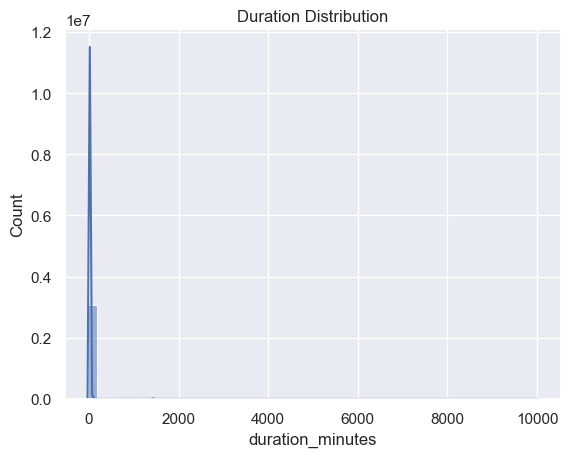

In [21]:
sns.histplot(df['duration_minutes'],bins=50,kde=True)
plt.title('Duration Distribution')
plt.show()


In [ ]:
df[df['duration_minutes']<=0].shape
print(f"There are {round(df[df['duration_minutes']<0].shape[0]/df.shape[0]*100,2)}% of the trips have negative duration")
df[df['duration_minutes']>=60].shape
print(f"There are {round(df[df['duration_minutes']>61].shape[0]/df.shape[0]*100,2)}% of the trips have more than 61 minutes")



There are 0.0% of the trips have negative duration
There are 0.73% of the trips have more than 61 minutes


In [32]:
print(f"Fraction of the records left after dropping outliers is {int(df_clean.shape[0] / df.shape[0] * 100)}%")



Fraction of the records left after dropping outliers is 99%


Q4 One-hot encoding

In [37]:
from sklearn.preprocessing import OneHotEncoder

# Make a copy and cast to string
df_model = df_clean.copy()
df_model['PULocationID'] = df_model['PULocationID'].astype(str)
df_model['DOLocationID'] = df_model['DOLocationID'].astype(str)

# Updated argument name
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X = encoder.fit_transform(df_model[['PULocationID', 'DOLocationID']])

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(encoder.get_feature_names_out())}")


Feature matrix shape: (3041344, 517)
Number of features: 517


Q7. 

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Target variable
y_train = df_model['duration_minutes'].values

# Train the linear regression model
lr = LinearRegression()
lr.fit(X, y_train)

# Predict on training data
y_pred = lr.predict(X)

# Compute RMSE
rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"RMSE on training data: {rmse:.2f} minutes")


RMSE on training data: 7.92 minutes


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Validation

In [40]:
from sklearn.metrics import mean_squared_error

# Step 1: Preprocessing (same as training)
df_val['tpep_pickup_datetime'] = pd.to_datetime(df_val['tpep_pickup_datetime'])
df_val['tpep_dropoff_datetime'] = pd.to_datetime(df_val['tpep_dropoff_datetime'])
df_val['duration'] = df_val['tpep_dropoff_datetime'] - df_val['tpep_pickup_datetime']
df_val['duration_minutes'] = df_val['duration'].dt.total_seconds() / 60

# Filter outliers
df_val = df_val[(df_val['duration_minutes'] > 0) & (df_val['duration_minutes'] < 60)].copy()

# Cast to string
df_val['PULocationID'] = df_val['PULocationID'].astype(str)
df_val['DOLocationID'] = df_val['DOLocationID'].astype(str)

# Prepare features (reusing fitted encoder — dv or encoder)
# If using DictVectorizer:
dicts_val = df_val[['PULocationID', 'DOLocationID']].to_dict(orient='records')
X_val = dv.transform(dicts_val)

# Predict and calculate RMSE
y_val = df_val['duration_minutes'].values
y_pred = lr.predict(X_val)
rmse_val = mean_squared_error(y_val, y_pred, squared=False)

print(f"RMSE on validation data: {rmse_val:.2f} minutes")


RMSE on validation data: 15.89 minutes


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
